In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('youtube_comments_cleaned.csv')

In [3]:
df.head()

,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032225 entries, 0 to 1032224
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   CommentID        1032225 non-null  object
 1   VideoID          1032225 non-null  object
 2   VideoTitle       1032225 non-null  object
 3   AuthorName       1031594 non-null  object
 4   AuthorChannelID  1032225 non-null  object
 5   CommentText      1032225 non-null  object
 6   Sentiment        1032225 non-null  object
 7   Likes            1032225 non-null  int64 
 8   Replies          1032225 non-null  int64 
 9   PublishedAt      1032225 non-null  object
 10  CountryCode      1032225 non-null  object
 11  CategoryID       1032225 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 94.5+ MB


In [5]:
df.isnull().sum()

CommentID            0
VideoID              0
VideoTitle           0
AuthorName         631
AuthorChannelID      0
CommentText          0
Sentiment            0
Likes                0
Replies              0
PublishedAt          0
CountryCode          0
CategoryID           0
dtype: int64

In [6]:
df.columns

Index(['CommentID', 'VideoID', 'VideoTitle', 'AuthorName', 'AuthorChannelID',
       'CommentText', 'Sentiment', 'Likes', 'Replies', 'PublishedAt',
       'CountryCode', 'CategoryID'],
      dtype='object')

In [7]:
text_df = df.drop(['CommentID', 'VideoID', 'VideoTitle', 'AuthorName', 'AuthorChannelID','Sentiment',
       'Likes', 'Replies', 'PublishedAt','CountryCode', 'CategoryID'], axis=1)
text_df.head()

,CommentText
0,Anyone know what movie this is?
1,The fact they're holding each other back while...
2,waiting next video will be?
3,Thanks for the great video.\n\nI don't underst...
4,Good person helping good people.\nThis is how ...


In [8]:
print(text_df['CommentText'].iloc[0],"\n")
print(text_df['CommentText'].iloc[1],"\n")
print(text_df['CommentText'].iloc[2],"\n")
print(text_df['CommentText'].iloc[3],"\n")
print(text_df['CommentText'].iloc[4],"\n")

Anyone know what movie this is? 

The fact they're holding each other back while equally being most aggressive 😂😂 

waiting next video will be? 

Thanks for the great video.

I don't understand why the DB continues to be accesible through port 8080 when the local machine connects to the docker container through port 5432? Or, why is it not possible to make GET requests to port 5432 on my local machine?

Is it just because the port 5432 is only the port used to connect the app to the database, but the app itself is still handling HTTP through 8080? So an incoming request hits 8080, then goes through 5432 to get to the database? 

Good person helping good people.
This is how it is in America with the exception of NY and DC. 



In [9]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032225 entries, 0 to 1032224
Data columns (total 1 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   CommentText  1032225 non-null  object
dtypes: object(1)
memory usage: 7.9+ MB


In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# Download required NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mihir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mihir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def data_processing(CommentText):
    CommentText = CommentText.lower()
    CommentText = re.sub(r"https?\S+|www\S+", '', CommentText)  # Remove URLs(Uniform Resource loacator)
    CommentText = re.sub(r'@\w+|\#', '', CommentText)  # Remove mentions and hashtags
    CommentText = re.sub(r'[^\w\s]', '', CommentText)  # Remove punctuation
    CommentText_tokens = word_tokenize(CommentText)  # Tokenize text
    filtered_text = [w for w in CommentText_tokens if w not in stop_words]  # Remove stopwords
    return " ".join(filtered_text)

text_df['text'] = text_df['CommentText'].apply(data_processing)

In [12]:
text_df = text_df.drop_duplicates('CommentText')

In [13]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [14]:
text_df['CommentText'] = text_df['CommentText'].apply(lambda x: stemming(x))

In [15]:
text_df.head()

,CommentText,text
0,Anyone know what movie this is?,anyone know movie
1,The fact they're holding each other back while...,fact theyre holding back equally aggressive
2,waiting next video will be?,waiting next video
3,Thanks for the great video.\n\nI don't underst...,thanks great video dont understand db continue...
4,Good person helping good people.\nThis is how ...,good person helping good people america except...


In [16]:
print(text_df['CommentText'].iloc[0],"\n")
print(text_df['CommentText'].iloc[1],"\n")
print(text_df['CommentText'].iloc[2],"\n")
print(text_df['CommentText'].iloc[3],"\n")
print(text_df['CommentText'].iloc[4],"\n")

Anyone know what movie this is? 

The fact they're holding each other back while equally being most aggressive 😂😂 

waiting next video will be? 

Thanks for the great video.

I don't understand why the DB continues to be accesible through port 8080 when the local machine connects to the docker container through port 5432? Or, why is it not possible to make GET requests to port 5432 on my local machine?

Is it just because the port 5432 is only the port used to connect the app to the database, but the app itself is still handling HTTP through 8080? So an incoming request hits 8080, then goes through 5432 to get to the database? 

Good person helping good people.
This is how it is in America with the exception of NY and DC. 



In [17]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989838 entries, 0 to 1032224
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   CommentText  989838 non-null  object
 1   text         989838 non-null  object
dtypes: object(2)
memory usage: 22.7+ MB


In [18]:
def polarity(CommentText):
    return TextBlob(CommentText).sentiment.polarity

In [19]:
text_df['polarity'] = text_df['CommentText'].apply(polarity)

In [20]:
text_df.head(10)

,CommentText,text,polarity
0,Anyone know what movie this is?,anyone know movie,0.000000
1,The fact they're holding each other back while...,fact theyre holding back equally aggressive,0.093750
2,waiting next video will be?,waiting next video,0.000000
3,Thanks for the great video.\n\nI don't underst...,thanks great video dont understand db continue...,0.166667
4,Good person helping good people.\nThis is how ...,good person helping good people america except...,0.700000
5,Dei løk de seim😂,dei løk de seim,0.000000
6,Number two because it looks the best with it,number two looks best,1.000000
7,Thank God we don’t have to listen to his drive...,thank god dont listen drivel anymore,0.000000
8,Very similar thing happened to me! We lived ne...,similar thing happened lived near beach stray ...,0.064063
9,im about to cry😢,im cry,0.000000


In [21]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [22]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [23]:
text_df.head(20)
print(text_df.columns)

Index(['CommentText', 'text', 'polarity', 'sentiment'], dtype='object')


<Axes: xlabel='sentiment', ylabel='count'>

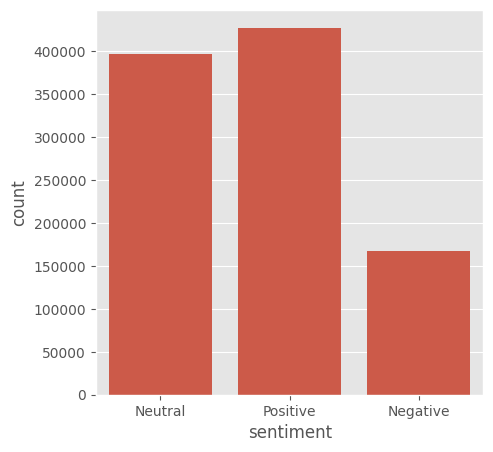

In [24]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

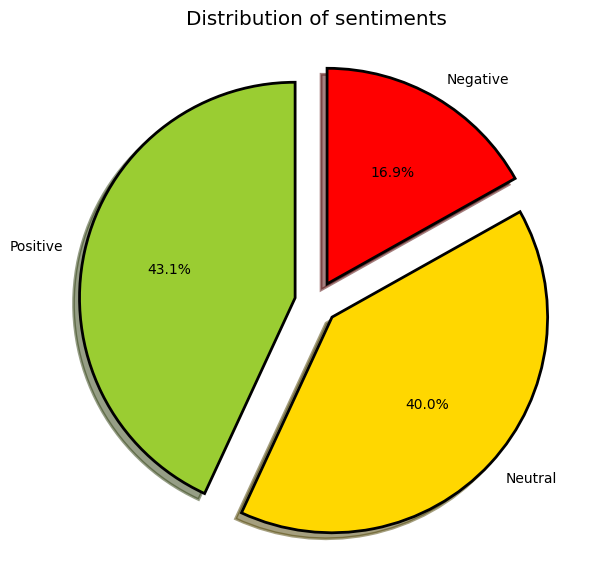

In [25]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [26]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
#pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,CommentText,text,polarity,sentiment
1,The fact they're holding each other back while...,fact theyre holding back equally aggressive,0.093750,Positive
3,Thanks for the great video.\n\nI don't underst...,thanks great video dont understand db continue...,0.166667,Positive
4,Good person helping good people.\nThis is how ...,good person helping good people america except...,0.700000,Positive
6,Number two because it looks the best with it,number two looks best,1.000000,Positive
8,Very similar thing happened to me! We lived ne...,similar thing happened lived near beach stray ...,0.064063,Positive


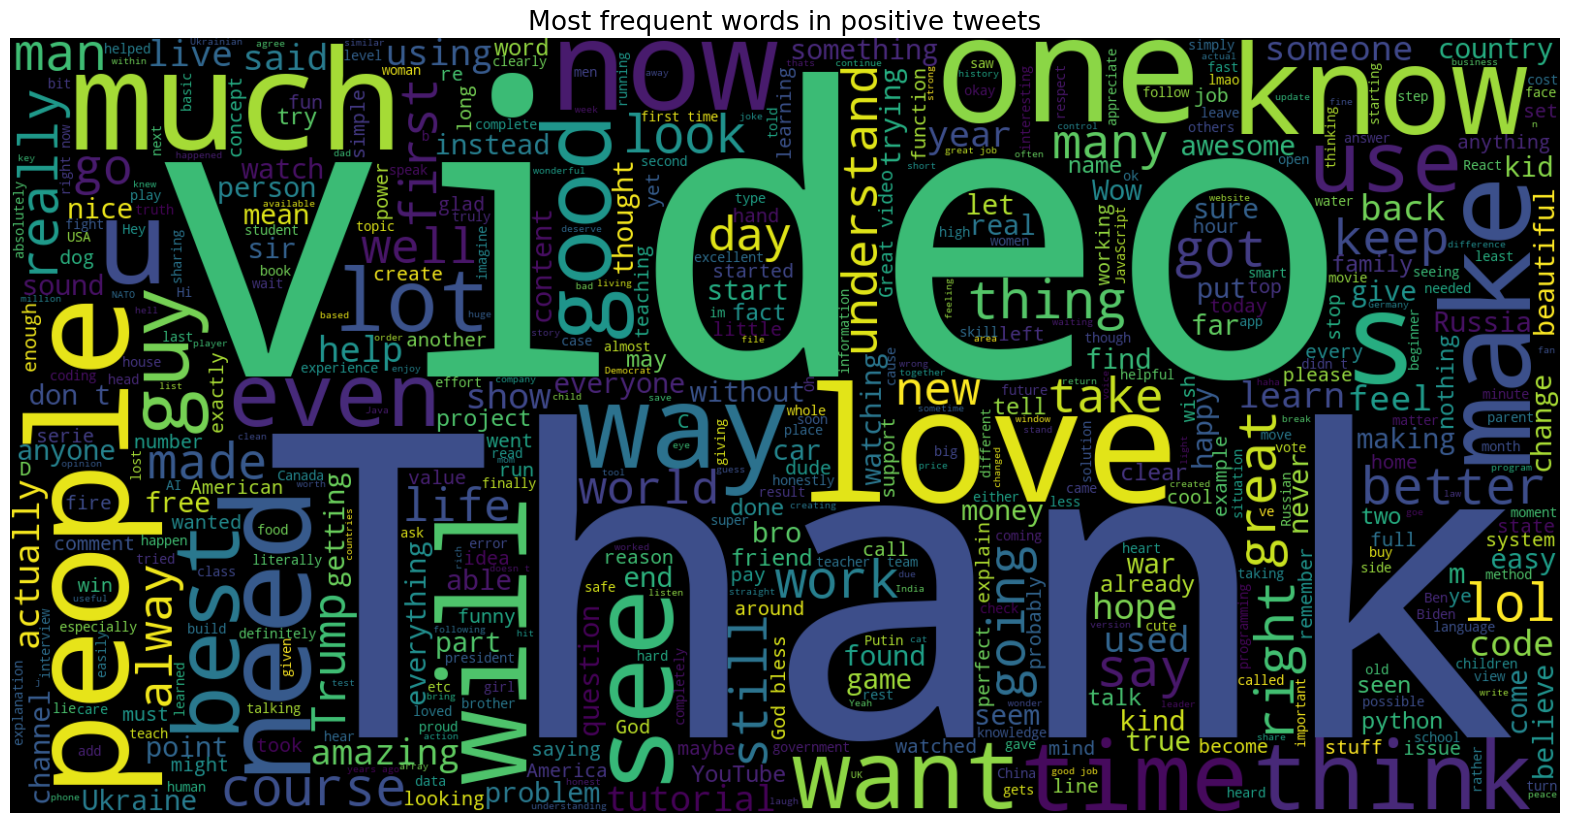

In [27]:
text = ' '.join([word for word in pos_tweets['CommentText']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [28]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
#neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,CommentText,text,polarity,sentiment
15,"Salish is amazing but so is Addie, a girl does...",salish amazing addie girl want hate js bc shes...,-0.200000,Negative
18,"@ALinchik, that is what happens when you selec...",happens select comedian aleader ukrainians res...,-0.033333,Negative
26,"Me and my friends occasionally hang out, and w...",friends occasionally hang someone always bring...,-0.166667,Negative
28,"I didn't take Spanish, but southern translates...",didnt take spanish southern translates heard c...,-0.193750,Negative
39,TikTok was a school for all they choosen to wa...,tiktok school choosen wake late already way ne...,-0.150000,Negative


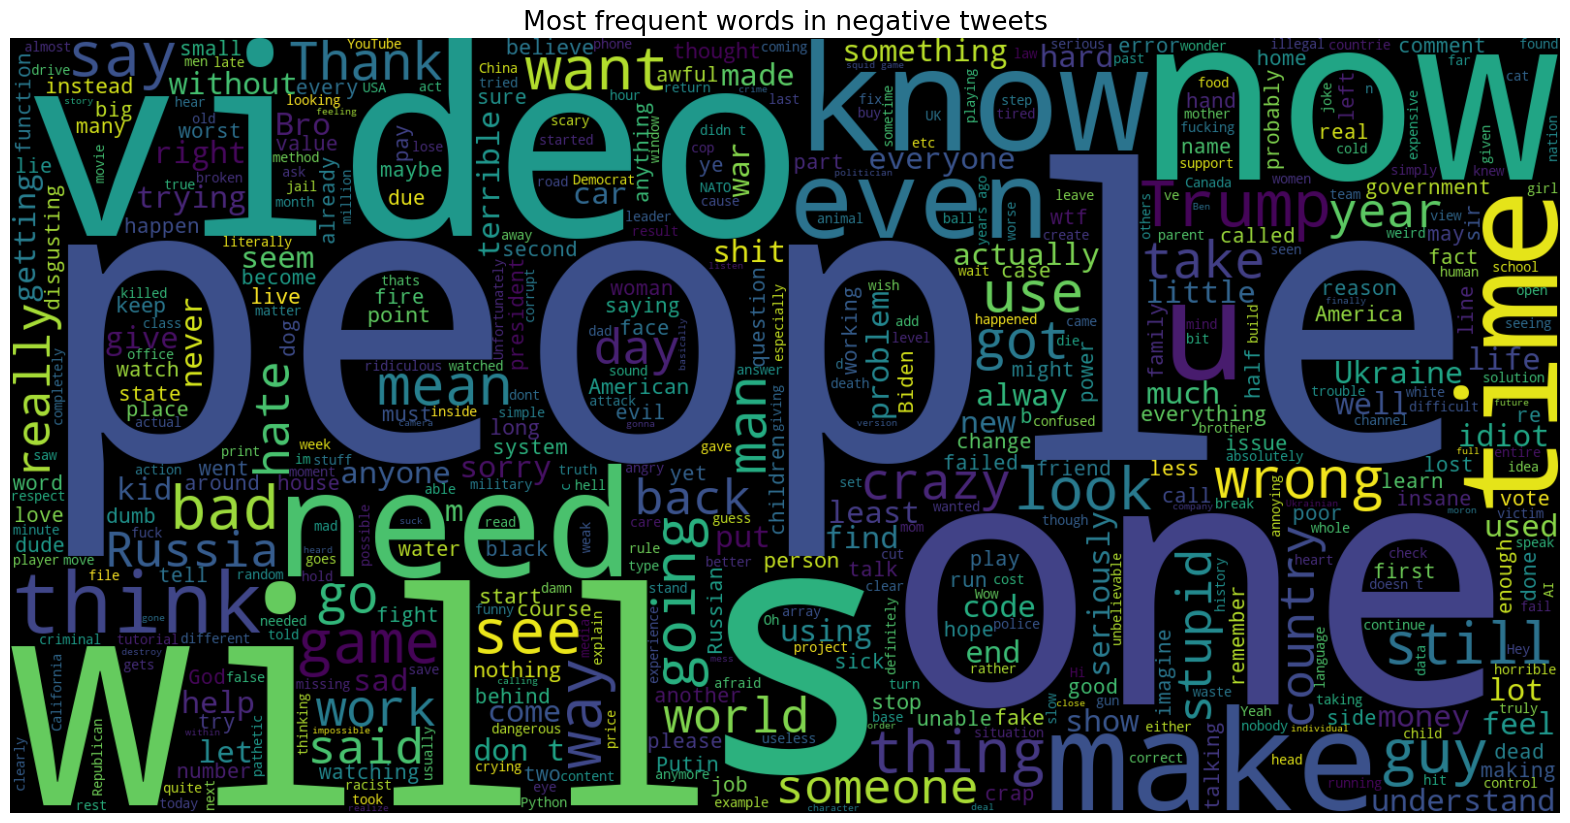

In [29]:
text = ' '.join([word for word in neg_tweets['CommentText']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [30]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
#neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,CommentText,text,polarity,sentiment
0,Anyone know what movie this is?,anyone know movie,0.0,Neutral
2,waiting next video will be?,waiting next video,0.0,Neutral
5,Dei løk de seim😂,dei løk de seim,0.0,Neutral
7,Thank God we don’t have to listen to his drive...,thank god dont listen drivel anymore,0.0,Neutral
9,im about to cry😢,im cry,0.0,Neutral


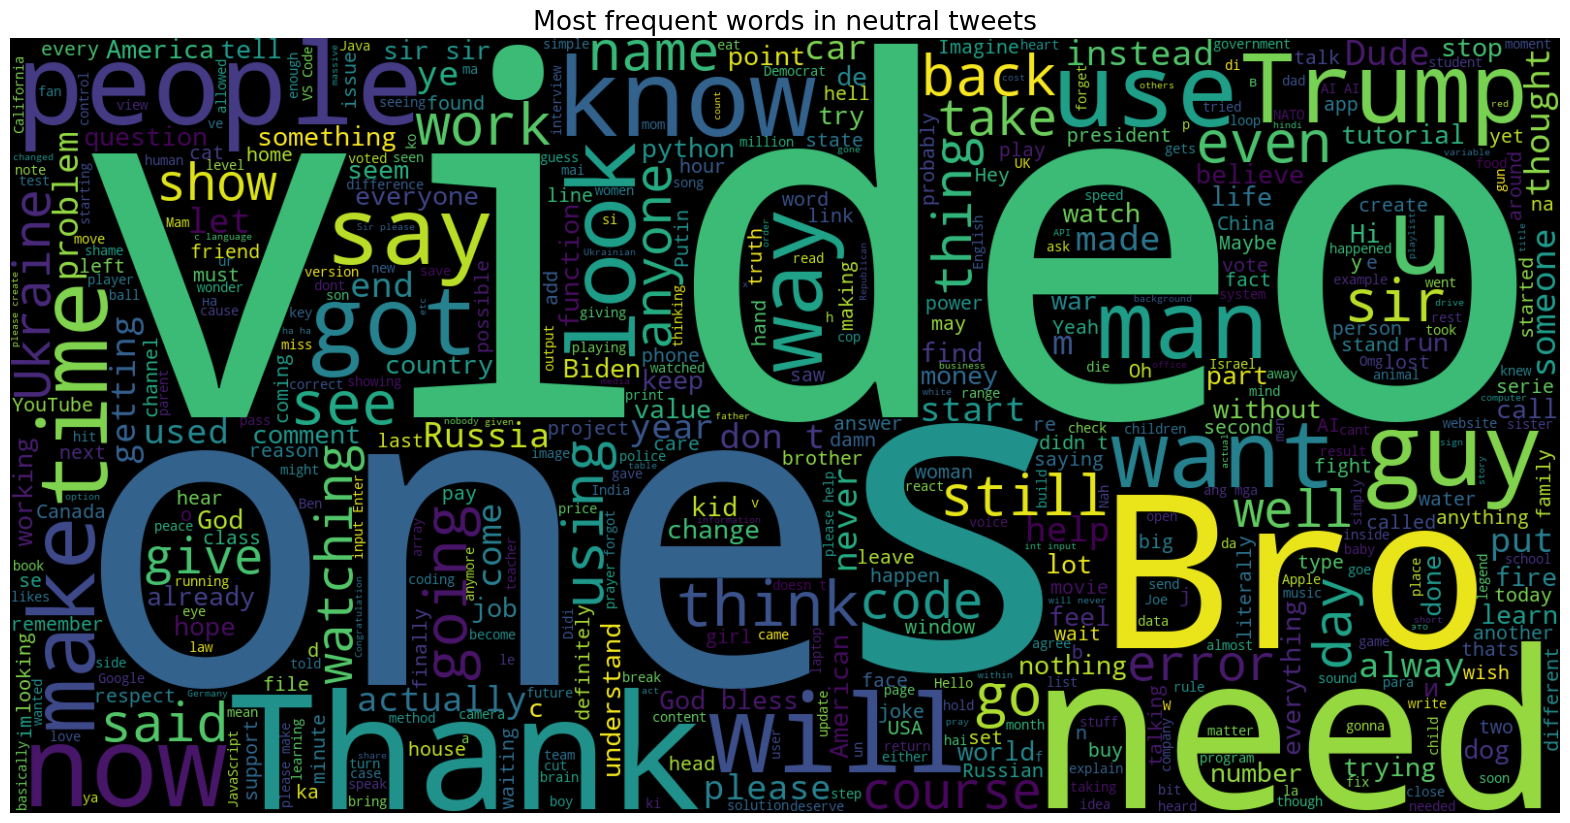

In [31]:
text = ' '.join([word for word in neutral_tweets['CommentText']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

In [32]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['CommentText'])

In [33]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 4057941

First 20 features:
 ['00' '00 00' '00 000' '00 0000' '00 01' '00 02' '00 03' '00 04' '00 05'
 '00 06' '00 07' '00 08' '00 09' '00 10' '00 100' '00 1000' '00 10000'
 '00 11' '00 12' '00 125']


In [70]:
X = text_df['CommentText']
Y = text_df['sentiment']

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
# Fit and transform only once
X = tfidf.fit_transform(X) 

In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [73]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (791870, 298462)
Size of y_train: (791870,)
Size of x_test: (197968, 298462)
Size of y_test: (197968,)


In [74]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 93.62%


C:\Users\Mihir\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [75]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[27800  2144  3450]
 [  775 76810  1657]
 [ 2138  2470 80724]]


              precision    recall  f1-score   support

    Negative       0.91      0.83      0.87     33394
     Neutral       0.94      0.97      0.96     79242
    Positive       0.94      0.95      0.94     85332

    accuracy                           0.94    197968
   macro avg       0.93      0.92      0.92    197968
weighted avg       0.94      0.94      0.94    197968



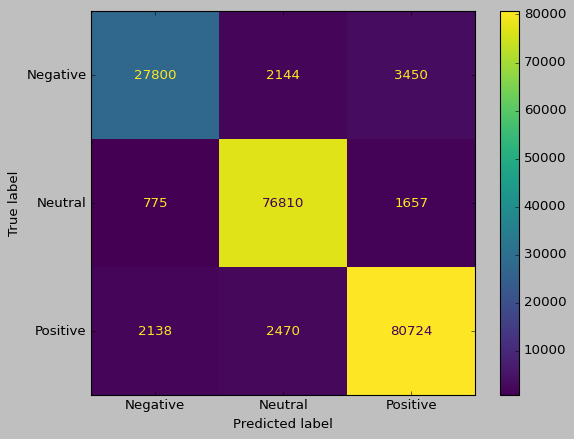

In [76]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [77]:
NBmodel = MultinomialNB()
NBmodel.fit(x_train, y_train)
nb_pred = NBmodel.predict(x_test)

In [78]:
nb_acc = accuracy_score(nb_pred, y_test)
print("Naive Bayes Test Accuracy: {:.2f}%".format(nb_acc * 100))

Naive Bayes Test Accuracy: 66.25%


In [79]:
print(confusion_matrix(y_test, nb_pred))
print("\n")
print(classification_report(y_test, nb_pred))

[[ 5352  1837 26205]
 [  247 43004 35991]
 [  121  2406 82805]]


              precision    recall  f1-score   support

    Negative       0.94      0.16      0.27     33394
     Neutral       0.91      0.54      0.68     79242
    Positive       0.57      0.97      0.72     85332

    accuracy                           0.66    197968
   macro avg       0.81      0.56      0.56    197968
weighted avg       0.77      0.66      0.63    197968



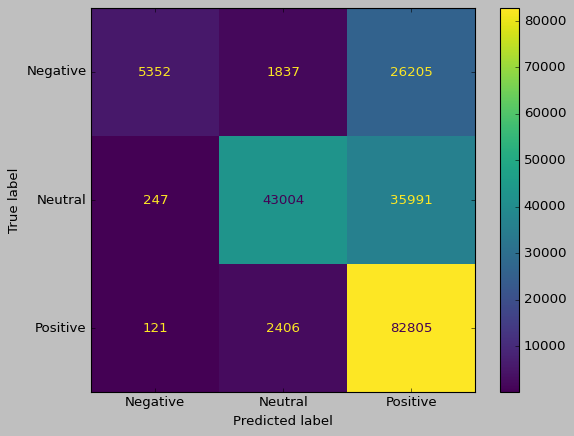

In [80]:
style.use('classic')
cm = confusion_matrix(y_test, nb_pred, labels=NBmodel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=NBmodel.classes_)
disp.plot()

In [81]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

rf_acc = accuracy_score(y_test, rf_pred)
print(f"Test Accuracy: {rf_acc * 100:.2f}%")

Test Accuracy: 66.37%


In [82]:
print(confusion_matrix(y_test, rf_pred))
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

[[    0 12418 20976]
 [    0 63539 15703]
 [    0 17488 67844]]

Classification Report:


C:\Users\Mihir\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mihir\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     33394
     Neutral       0.68      0.80      0.74     79242
    Positive       0.65      0.80      0.71     85332

    accuracy                           0.66    197968
   macro avg       0.44      0.53      0.48    197968
weighted avg       0.55      0.66      0.60    197968



C:\Users\Mihir\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


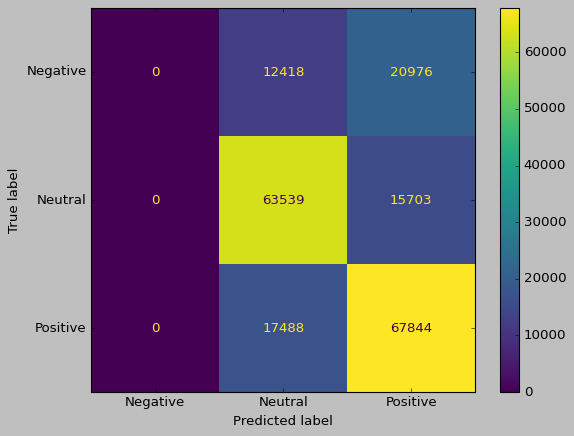

In [83]:
style.use('classic')
cm = confusion_matrix(y_test, rf_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=rf_model.classes_)
disp.plot()

In [84]:
import xgboost as xgb
# Encode categorical labels into numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert to 0, 1, 2
y_test_encoded = label_encoder.transform(y_test)  # Use the same transformation for test labels

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
xgb_model.fit(x_train, y_train_encoded)
xgb_pred = xgb_model.predict(x_test)

# Convert numerical predictions back to original labels
xgb_pred_labels = label_encoder.inverse_transform(xgb_pred)

xgb_acc = accuracy_score(y_test, xgb_pred_labels)
print(f"Test Accuracy: {xgb_acc * 100:.2f}%\n")

Test Accuracy: 78.00%



In [85]:
print(confusion_matrix(y_test, xgb_pred_labels))
print("\n")
print("Classification Report:")
print(classification_report(y_test, xgb_pred_labels))

[[12098 13067  8229]
 [  276 75230  3736]
 [ 1318 16931 67083]]


Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.36      0.51     33394
     Neutral       0.71      0.95      0.82     79242
    Positive       0.85      0.79      0.82     85332

    accuracy                           0.78    197968
   macro avg       0.82      0.70      0.72    197968
weighted avg       0.80      0.78      0.76    197968



In [ ]:
style.use('classic')
cm = confusion_matrix(y_test, xgb_pred, labels=xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=xgb_model.classes_)
disp.plot()

In [90]:
y_pred_logistic = logreg.predict_proba(x_test)[:, 1]  
y_pred_naive = NBmodel.predict_proba(x_test)[:, 1]  
y_pred_xgb = xgb_model.predict_proba(x_test)[:, 1]
y_pred_rf = rf_model.predict_proba(x_test)[:, 1]  

In [91]:
test_df = pd.DataFrame({'True': y_test, 'Logistic': y_pred_logistic , 'Naive_Bayes' : y_pred_naive , 'rf':y_pred_rf})

In [92]:
models = {
    'Logistic': logreg,
    'Naive_Bayes': NBmodel,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

# Convert y_test to binary format for ROC
class_labels = ['Negative', 'Neutral', 'Positive']
y_test_bin = label_binarize(y_test, classes=class_labels).ravel()  # Flatten

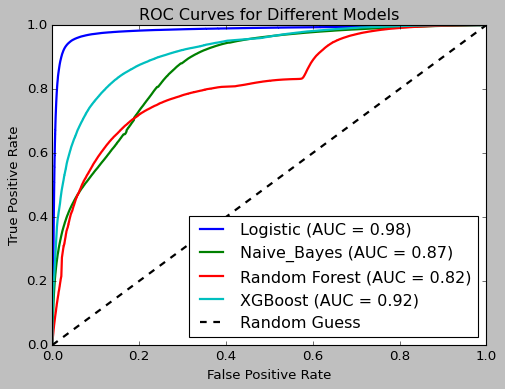

In [93]:
plt.figure(figsize=(7, 5))

for model_name, model in models.items():
    y_pred_proba = model.predict_proba(x_test).ravel()  
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model_accuracies = {
    'Logistic Regression': logreg_acc,
    'Naive Bayes': nb_acc,
    'xgb': xgb_acc , 
    'randomforecast':rf_acc
}
best_model_name = max(model_accuracies, key=model_accuracies.get)
print(f"\nBest Model: {best_model_name} with Accuracy: {model_accuracies[best_model_name] * 100:.2f}%")

import joblib

# Dictionary containing actual trained models, not just names
model_objects = {
    'Logistic Regression': logreg,
    'Naive Bayes': NBmodel,
    'xgb': xgb_model,  
    'randomforecast': rf_model
}
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model = model_objects[best_model_name] 

joblib.dump(best_model, 'best_model.pkl')
print(f"Best model '{best_model_name}' saved successfully!")



Best Model: Logistic Regression with Accuracy: 93.62%
Best model 'Logistic Regression' saved successfully!


In [95]:
with open("tfidf_vectorizer.pkl", "wb") as file:
    joblib.dump(tfidf, file)
print("TF-IDF vectorizer saved successfully as 'tfidf_vectorizer.pkl'.")

TF-IDF vectorizer saved successfully as 'tfidf_vectorizer.pkl'.


In [96]:
model = joblib.load('best_model.pkl')
print(type(model))  # Check the model type

vectorizer = joblib.load('tfidf_vectorizer.pkl')
print(type(vectorizer))  # Check vectorizer type

<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [97]:
from sklearn.base import BaseEstimator
if isinstance(model, BaseEstimator):
    print("Model is a valid scikit-learn model.")
else:
    print(f"Model is of type {type(model)} and not a scikit-learn model.")


Model is a valid scikit-learn model.
